In [1]:
import pandas as pd
import numpy as np
import pickle
missing_values = ["n/a", "na", "--", " "]
train_df = pd.read_csv("/home/cardosoo/492_19summer/MachineLearning/Data/Training couples, male DV.csv", na_values = missing_values )
test_df = pd.read_csv("/home/cardosoo/492_19summer/MachineLearning/Data/Testing couples, male DV.csv" , na_values = missing_values )



In [2]:
len(train_df.columns.tolist()),len(test_df.columns.tolist())

(173, 173)

number of missing data

In [3]:
train_df.isna().sum().sum(),test_df.isna().sum().sum()

(60, 307)

Filling missing Data with 0

In [4]:
train = train_df.fillna(0)
test = test_df.fillna(0)
train.isna().sum().sum(),test.isna().sum().sum()

(0, 0)

Let's see what intersects

In [5]:
# columns may have same names but different cases
train_cols = [x.lower() for x in train.columns.tolist()] 
test_cols = [x.lower() for x in test.columns.tolist()]
print(len(train_cols))
print(len(test_cols))
A = set(train_cols)
B = set(test_cols)
C = A & B
C = A & B

len(C)

173
173


171

In [6]:
print("Non intersecting column names: ")
print("A-C",A - C)
print("B-C",B-C)
D = A - C
E = B - C
Not_C = D | E
for x in Not_C:
    if x in train_cols:
        train_cols.remove(x)
    if x in test_cols:
        test_cols.remove(x)
print(len(train_cols),len(test_cols))

train_X = train_cols[0:len(train_cols)-1]# not including digging actor
y = train_cols[len(train_cols)-1]
test_X = test_cols[0:len(test_cols)-1]
train_X.sort()
test_X.sort()
train_X.append(y)
test_X.append(y) 
print(train_X == test_X)

train_cols = train.columns.tolist() 
test_cols = test.columns.tolist()
# making the column names lowercase so we can index the features we want
train_cols = [x.lower() for x in train_cols]
test_cols = [x.lower() for x in test_cols]

#reassigning column names
train.columns = train_cols
test.columns = test_cols


Non intersecting column names: 
A-C {'statustot', 'fstatustot'}
B-C {'status2', 'fstatus2'}
171 171
True


In [7]:
len(train_X), len(test_X )
train = train[train_X]
test = test[test_X]
train_data = train.values.astype('float')
test_data = test.values.astype('float')
cols = train_data.shape[1]


# Joining sample A and sample B together
full_data = np.concatenate((train_data,test_data))
full_data.shape,train_data.shape,test_data.shape

y = full_data[:,cols-1]
X = full_data[:,0:cols-1]
X.shape, y.shape

((2050, 170), (2050,))

# Helper functions

In [8]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import layers
from keras import models
"""
Builds a nn regression modelall_val_mae_histories, all_val_loss_histories, all_loss_histories, all_mae_histories
"""
def build_model(units,layerz,metric,shape):
    model = models.Sequential()
    model.add(layers.Dense(units, activation = 'relu', 
                           input_shape = (shape,)))
    for layer in range(layerz):
        model.add(layers.Dense(units, activation = 'relu'))
    model.add(layers.Dense(1)) #linear layer
    model.compile(optimizer = 'rmsprop', loss = 'logcosh', metrics = metric  )
    return model





"""
params: units, layerz, metric,num_epochs
returns : mae, loss, validation loss and validition mae histories for each fold
          tuple( all_val_mae_histories, all_val_loss_histories, all_loss_histories, all_mae_histories)
"""
def validaton(hyper_parameters,shape,data):
    k = 4
    
    units, layerz = hyper_parameters['units'], hyper_parameters['layerz']
    metric,num_epochs = hyper_parameters['metric'], hyper_parameters['num_epochs']
    train_data,train_targets = data['train'],data['target']
    
    num_val_samples = len(train_data) // k
    all_val_mae_histories = []
    all_val_loss_histories = []
    all_loss_histories = []
    all_mae_histories = []
    all_val_mape_histories = []
    
    print("val_samples: " + str(num_val_samples))
    for i in range(k):
        print('\tprocessing fold #', i)
        start = i*num_val_samples
        stop = (i + 1) * num_val_samples
        val_data = train_data[start:stop]
        val_target = train_targets[start:stop]

        partial_train_data = np.concatenate( (train_data[:start], train_data[stop:]) ,axis = 0)
        partial_train_target = np.concatenate( (train_targets[:start],train_targets[stop:]), axis = 0) 

        model = build_model(units, layerz, metric,shape)
        history = model.fit(partial_train_data, partial_train_target, epochs = num_epochs, batch_size = 1, verbose = 0,
                            validation_data = (val_data, val_target) )


        val_mae_history = history.history['val_mean_absolute_error']
        val_loss_history = history.history['val_loss']
        loss_history = history.history['loss']
        mae_history = history.history['mean_absolute_error']
        val_mape_history = history.history['val_mean_absolute_percentage_error']
        
        all_val_mae_histories.append(val_mae_history)  
        all_val_loss_histories.append(val_loss_history)
        all_loss_histories.append(loss_history)
        all_mae_histories.append(mae_history)
        all_val_mape_histories.append(val_mape_history)
        
    return all_val_mae_histories, all_val_loss_histories, all_loss_histories, all_mae_histories,all_val_mape_histories

"""
returns the histories of all the P * K folds
"""
def iterated_validation(num_iterations,hyper_parameters,shape,data):
    all_val_mae_histories = []
    all_val_loss_histories = []
    all_loss_histories = []
    all_mae_histories = []
    all_val_mape_histories = []
    train_data,train_targets = data['train'],data['target']
    for i in range(num_iterations):
        print("iteration: "+str(i+1))
            # shuffle training data
        rows = np.arange(train_targets.size)
        indexes = shuffle(rows)
        train_data = train_data[indexes]
        train_targets = train_targets[indexes]
        print("\tStarting indexes for training " +str(indexes[0:5]))
        
        histories = validaton(hyper_parameters,shape,data)
        all_val_mae_histories.extend(histories[0])
        all_val_loss_histories.extend(histories[1])
        all_loss_histories.extend(histories[2])
        all_mae_histories.extend(histories[3])
        all_val_mape_histories.extend(histories[4])
        
    return all_val_mae_histories, all_val_loss_histories, all_loss_histories, all_mae_histories,all_val_mape_histories

"""
Returns the mean for each elements returned in by the 
iterated_validation or validation function
"""
def average_folds(histories):
    all_val_mae_histories, all_val_loss_histories, all_loss_histories, all_mae_histories,all_val_mape_histories = histories
    averages = []
    num_epochs = len(all_val_mae_histories[0])
    averages.append([np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)])
    averages.append([np.mean([x[i] for x in all_val_mae_histories]) for i in range(num_epochs)])
    averages.append([np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)])
    averages.append([np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)])
    averages.append([np.mean([x[i] for x in all_val_mape_histories]) for i in range(num_epochs)])
    return averages

"""
Creates and plots 4 subplots. That represents 
the loss and Mae for the training and validation set
"""
def plots(histories):
    val_mae = 1
    val_loss = 3
    val_mape = 4
    indices = [val_mae,val_mape]
    fig, axes = plt.subplots(1,2,figsize=(12,12))
    axes.reshape((2,))
    fig.suptitle('overfitting with different size features')
    color = ["b","r"]
    name = ["MAE","MAPE"]
    for i , axis in enumerate(axes):
        axis.plot(histories[indices[i]], color[i], label = name[i])
        axis.set_xlabel('Epochs')
        if i == 0:
            axis.set_ylabel('Validation mae')
        else: axis.set_ylabel('Validation mape')
        plt.legend()
    print("NN had a " + str(np.min(histories[val_mae])) +" MAE value")
    print("NN  had a " + str(np.min(histories[val_mape])) +" MAPE value")
    print("NN  had a " + str(np.min(histories[val_loss])) +" Loss value")
    print()
    
    
def plot_features(features, names, smooth=0):
    val_mae_index = 1
    val_loss_index = 3
    epochs = range(1,len(features[names[0]][val_mae_index])+1)
    color = ["b","r","g","k"]
    plt.figure(figsize=(12,12))
    plt.title('overfitting with different size features')
    plt.xlabel('Epochs')
    plt.ylabel('Validation mae')
    for i,name in enumerate(names):
        if smooth != 0:
            plt.plot(epochs, smooth_curve(features[names[i]][val_mae_index]), color[i], label=name) 
        else:
            plt.plot(epochs, features[names[i]][val_mae_index], color[i], label=name) 
        plt.legend()
        print(name + " had a " + str(np.min(features[names[i]][val_mae_index])) +" MAE value")
        print(name + " had a " + str(np.min(features[names[i]][val_loss_index])) +" Loss value")
        print()
    plt.show()
    
import matplotlib.pyplot as plt
"""
Used for plotting different kinds of models
"""
def plot_models(histories):
    epochs = range(1,len(histories[0]["val_loss"])+1)
    color = ["b","r","g","k"]
    name = ["tiny","small", "big", "huge"]
    plt.figure(figsize=(12,12))
    plt.title('overfitting with different size capacity')
    plt.xlabel('Epochs')
    plt.ylabel('Validation mae')
    for i,history in enumerate(histories):

        plt.plot(epochs, history["val_mean_absolute_error"], color[i], label=name[i]) 
        plt.legend()
        print(name[i] + " capacity min " + str(np.min(history["val_loss"])) +" loss")
        print()
        print(name[i] + " capacity min " + str(np.min(history["val_mean_absolute_error"])) +" mean_absolute_error")
        print()
    plt.show()
    
"""
Manipulates the data such that it looks smoother when you plot it
"""
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point*(1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points







Using TensorFlow backend.


In [9]:
ratio = 0.8
split = int(np.floor(X.shape[0]*ratio))

hyper_parameters = dict(units = 50, layerz = 3, metric =['mae','mape'], num_epochs = 300)
shape = X.shape[1]
train_data = X[0:split,:]
train_target = y[0:split]
data = dict(train = train_data, target = train_target)

histories = iterated_validation(1, hyper_parameters,shape,data)

iteration: 1
	Starting indexes for training [1176   75  744  722 1193]
val_samples: 410
	processing fold # 0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
	processing fold # 1
	processing fold # 2
	processing fold # 3


# Experiment 1:
units = 48, layerz = 3



In [10]:
#note your loss and accuracy graphs may look different because of initial randomizaiton
pickle_out = open("PostExperiment1RM", "wb")
pickle.dump(histories,pickle_out)
pickle_out.close()

In [11]:
pickle_in = open("PostExperiment1RM", "rb")
histories = pickle.load(pickle_in)
pickle_in.close()

No handles with labels found to put in legend.


NN had a 1.1527634001064408 MAE value
NN  had a 924.4526034672813 MAPE value
NN  had a 0.6625162550952376 Loss value



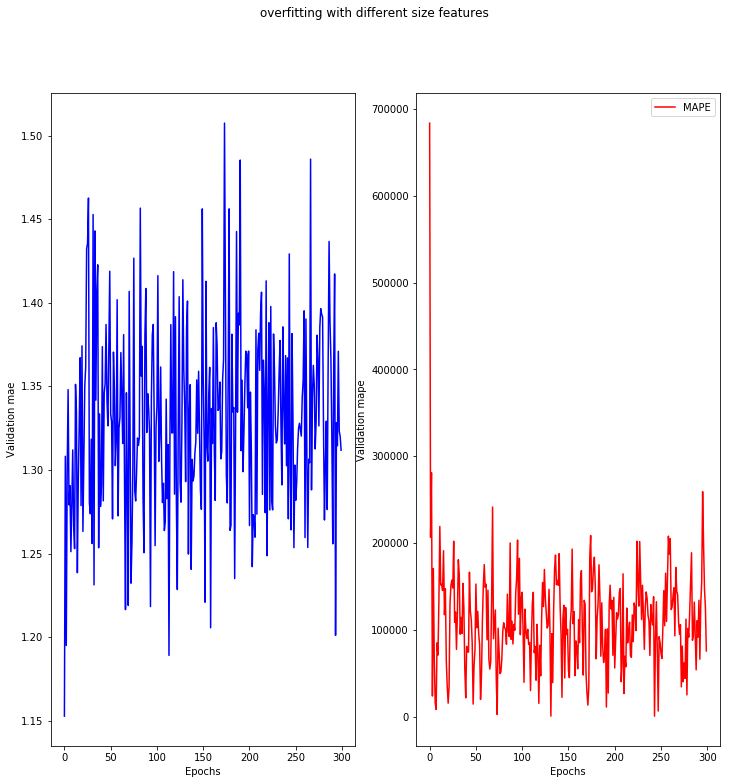

In [12]:
average = average_folds(histories)
plots(average)

In [ ]:
num = 10 #num of selected features
#corrolation, Mutual Information, Mean decrease impurities ,Mean decrease accuracy
train_datas = []
test_datas = []
ratio = 0.8
split = int(np.floor(X.shape[0]*ratio))

hyper_parameters = dict(units = 42, layerz = 2, metric =['mae','mape'], num_epochs = 300)
shape = X.shape[1]
train_data = X[0:split,:]
train_target = y[0:split]
data = dict(train = train_data, target = train_target)

histories = iterated_validation(1, hyper_parameters,shape,data)

iteration: 1
	Starting indexes for training [ 52 528 293 383 805]
val_samples: 410
	processing fold # 0
	processing fold # 1
	processing fold # 2


In [ ]:
average = average_folds(histories)
plots(average)

In [ ]:
plt.plot(average[1])

In [ ]:
from keras import models
from keras import layers
from keras import regularizers

def Models(num):
    models = dict()
    models[0] = build_model0
    models[1] = build_model1
    models[2] = build_model2
    models[3] = build_model3
    models[4] = build_model4
    return models[num]


def build_model4(units,layerz,metric,shape): # normal
    model = models.Sequential()
    model.add(layers.Dense(units, activation = 'relu', 
                           input_shape = (shape,)))
    for layer in range(layerz):
        model.add(layers.Dense(units, activation = 'relu'))
    model.add(layers.Dense(1)) #linear layer
    model.compile(optimizer = 'adam', loss = 'mse', metrics = [metric]  )
    return model
        

def build_model0(units,layerz,metric,shape):
    model = models.Sequential()
    model.add(layers.Dense(units, activation = 'relu', 
                           input_shape = (shape,)))
    for layer in range(layerz):
        model.add(layers.Dense(units, activation = 'relu'))
    model.add(layers.Dense(1)) #linear layer
    model.compile(optimizer = 'rmsprop', loss = 'logcosh', metrics =[metric] )
    return model

def build_model1(units,layerz,metric,shape): # regularizaion
    model = models.Sequential()
    model.add(layers.Dense(units, activation = 'relu', kernel_regularizer = regularizers.l2(0.001),
                           input_shape = (shape,)))
    for layer in range(layerz):
        model.add(layers.Dense(units, activation = 'relu', kernel_regularizer = regularizers.l2(0.001)))
    model.add(layers.Dense(1)) #linear layer
    model.compile(optimizer = 'rmsprop', loss = 'logcosh', metrics =[metric] )
    return model

def build_model2(units,layerz,metric,shape): #dropout
    model = models.Sequential()
    model.add(layers.Dense(units, activation = 'relu',
                           input_shape = (shape,)))
    model.add(layers.Dropout(0.5))
    for layer in range(layerz):
        model.add(layers.Dense(units, activation = 'relu'))
        model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1)) #linear layer
    model.compile(optimizer = 'rmsprop', loss = 'logcosh', metrics =[metric] )
    return model

def build_model3(units,layerz,metric,shape): # all use all
    model = models.Sequential()
    model.add(layers.Dense(units, activation = 'relu', kernel_regularizer = regularizers.l2(0.001),
                           input_shape = (shape,)))
    model.add(layers.Dropout(0.5))
    for layer in range(layerz):
        model.add(layers.Dense(units, activation = 'relu',kernel_regularizer = regularizers.l2(0.001)))
        model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1)) #linear layer
    model.compile(optimizer = 'rmsprop', loss = 'logcosh', metrics =[metric] )
    return model   



In [ ]:
metric = "mae"
def Histories(num,shape):
    build_model = Models(num)
    model0 = build_model(50,1,metric,shape) # tiny
    model1 = build_model(50,2,metric,shape) # small capacity
    model2 = build_model(64,3,metric,shape) # big capacity
    model3 = build_model(100,4,metric,shape) # huge capacity
    modelz = [model0, model1,model2,model3]
    histories = []
    for model in modelz:
        histories.append(
            model.fit(partial_x_train, partial_y_train, epochs=100, batch_size = 512, verbose = 0,validation_data = (x_val,y_val)).history
        )
    return histories

Normalize Data

And split Validation set

In [ ]:
# normalize
ratio = 0.8
split = int(np.floor(X.shape[0]*ratio))
mean = X[0:split].mean(axis = 0)
partial_x_train = X.copy()[0:split]
partial_x_train -= mean
std = partial_x_train.std(axis = 0)
partial_x_train /= std
partial_y_train = y.copy()[0:split]

# split validation into two
validation_X = X.copy()[split:]
validation_y = y.copy()[split:]
# validation set
split = int(np.floor(validation_X.shape[0]*ratio))
x_val = validation_X[0:split] - mean # use mean from training data
x_val /= std # use standard deviation from training data
y_val = validation_y[0:split]

# test set
x_test = validation_X[split:] - mean
x_test /= std
y_test = validation_y [split:]



In [ ]:
partial_x_train.shape

In [ ]:
validation_X.shape

# Model 0

In [ ]:
histories0 = Histories(0,X.shape[1])
plot_models(histories0)

In [ ]:

plot_models(histories0)

# Model 1


In [ ]:
histories1 = Histories(1,X.shape[1])
plot_models(histories1)